In [100]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler

### 获取数据

In [101]:
new_data = pd.read_csv('../data/new_data.csv')

In [102]:
new_data = new_data.drop(['Unnamed: 0', 'light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'], axis=1)

In [103]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float64
 1   temperature  75552 non-null  float64
 2   humidity     75552 non-null  float64
 3   pressure     75552 non-null  float64
 4   visibility   75552 non-null  float64
 5   holiday      75552 non-null  float64
 6   minute       75552 non-null  float64
 7   week         75552 non-null  float64
 8   year         75552 non-null  float64
dtypes: float64(9)
memory usage: 5.2 MB


In [104]:
new_data = new_data.astype(np.float32)

In [105]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float32
 1   temperature  75552 non-null  float32
 2   humidity     75552 non-null  float32
 3   pressure     75552 non-null  float32
 4   visibility   75552 non-null  float32
 5   holiday      75552 non-null  float32
 6   minute       75552 non-null  float32
 7   week         75552 non-null  float32
 8   year         75552 non-null  float32
dtypes: float32(9)
memory usage: 2.6 MB


2021年、2022年、2023年年初电力负荷均出现了明显的先下降后上升过程，但原因不明，需要和电力公司沟通，了解原因。因此在模型训练和测试时选择将这段时间的数据忽略。

删去2021-1-21到2021-2-6，2022-2-9到2022-2-24，2023-1-26到2023-2-13的数据

In [106]:
drop_index = [i for i in range(1920, 3552)] + [i for i in range(38784, 40320)] + [i for i in range(72480, 74304)]
new_data = new_data.drop(drop_index, axis=0)

In [107]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        70560 non-null  float32
 1   temperature  70560 non-null  float32
 2   humidity     70560 non-null  float32
 3   pressure     70560 non-null  float32
 4   visibility   70560 non-null  float32
 5   holiday      70560 non-null  float32
 6   minute       70560 non-null  float32
 7   week         70560 non-null  float32
 8   year         70560 non-null  float32
dtypes: float32(9)
memory usage: 3.0 MB


划分训练集和测试集。2021年、2022年前11个月和2023年的数据作为训练集，2022年12月的数据作为测试集

In [108]:
train1 = new_data.loc[:1919]
train2 = new_data.loc[3552:38783]
train3 = new_data.loc[40320:67103]
train4 = new_data.loc[70080:72479]
train5 = new_data.loc[74304:]
test = new_data.loc[67104:70079]

In [109]:
train = pd.concat([new_data.loc[:67103], new_data.loc[70080:]], axis=0)

In [110]:
print(len(train))
print(len(test))

67584
2976


对训练集和测试集数据归一化

In [111]:
scaler = MinMaxScaler()
scaler = scaler.fit(train)  # fit，在这里本质是生成min(x)和max(x)
train_result1 = scaler.transform(train1)  # 结果为ndarray类型
train_result2 = scaler.transform(train2)
train_result3 = scaler.transform(train3)
train_result4 = scaler.transform(train4)
train_result5 = scaler.transform(train5)
test_result = scaler.transform(test)

In [112]:
scaler

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [113]:
train_result1.shape

(1920, 9)

In [114]:
train_result2.shape

(35232, 9)

In [115]:
train_result3.shape

(26784, 9)

In [116]:
train_result4.shape

(2400, 9)

In [117]:
train_result5.shape

(1248, 9)

In [118]:
test_result.shape

(2976, 9)

生成训练数据

In [119]:
#  将预测时刻的气象数据也作为输入，为了保证输入序列的特征数一致，将预测时刻输入的负荷设为1
#  可以做个比较，有预测时刻的气象信息与没有预测时刻的气象信息。感觉有预测时刻的气象信息作为输入，模型预测准确性会受到天气预报准确性的影响。
#  生成的样本起始时刻依次相差15分钟
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw+1):
        train_seq = copy.deepcopy(input_data[i:i+tw])
        train_seq[tw-96:tw, 0] = 1
        train_label = input_data[i+tw-96:i+tw, 0]
        inout_seq.append((torch.tensor(train_seq) ,torch.tensor(train_label)))
    return inout_seq

In [120]:
train_seq1 = create_inout_sequences(train_result1, 288)
train_seq2 = create_inout_sequences(train_result2, 288)
train_seq3 = create_inout_sequences(train_result3, 288)
train_seq4 = create_inout_sequences(train_result4, 288)
train_seq5 = create_inout_sequences(train_result5, 288)
train_seq = train_seq1 + train_seq2 + train_seq3 + train_seq4 + train_seq5

In [121]:
len(train_seq)

66149

生成测试数据

In [122]:
test_seq = create_inout_sequences(test_result, 288)

In [123]:
len(test_seq)

2689

训练样本的数量为66149，每个训练样本包括特征和标签，其中特征为前192个时刻和后96个时刻的气象数据和负荷值（后96个时刻的负荷值用1代替，只是占个位置，保证输入序列的特征数一致，没有实际含义），标签为后96个时刻的负荷值。

使用前48小时和未来24小时的数据预测未来24小时的负荷

设置批量大小为96

In [124]:
trainloader = torch.utils.data.DataLoader(train_seq, batch_size=96, shuffle=True)
testloader = torch.utils.data.DataLoader(test_seq, batch_size=len(test_seq))

In [125]:
len(trainloader)

690

In [126]:
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([96, 288, 9])
torch.Size([96, 96])


### 建立LSTM模型并训练

In [127]:
class LstmNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(9, 100, 1, batch_first=True)  # 这个lstm的输入为9个神经元，输出为100个神经元，每个训练样本一次训练这个lstm被重复执行了288次，
        self.layer2 = nn.Linear(100, 1)  # 或者形象地说这个lstm结构在时间上的长度为288。
        
    def forward(self, x):
        y1, _ = self.layer1(x)
        y1 = y1[:, -96:, :]
        y2 = self.layer2(y1)
        return y2.reshape(-1, 96)

In [128]:
# 49*1*15 15*50  49*1*50  49*50 50*1 49*1  # 批量大小为1
# 49*64*15 15*50 49*64*50  50*1 49*64*1  # 批量大小为64
# 96*288*9 9*100 96*288*100 96*96*100 100*1 96*96*1 96*96  # 批量大小为96，batch_first=True

In [129]:
lstmnet = LstmNet()

In [130]:
lr = 0.001
opt = optim.Adam(lstmnet.parameters(), lr=lr)

In [131]:
loss_function = nn.MSELoss()  # 方差/平均平方误差

In [132]:
epochs = 1
for epoch in range(epochs):
    i = 0
    for xb, yb in trainloader:
        y = lstmnet(xb)
        loss = loss_function(y, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        if i%10 == 0:
            print(loss.data)

tensor(0.0338)
tensor(0.0295)
tensor(0.0272)
tensor(0.0300)
tensor(0.0253)
tensor(0.0240)
tensor(0.0232)
tensor(0.0211)
tensor(0.0219)
tensor(0.0215)
tensor(0.0198)
tensor(0.0186)
tensor(0.0200)
tensor(0.0196)
tensor(0.0172)
tensor(0.0176)
tensor(0.0189)
tensor(0.0154)
tensor(0.0179)
tensor(0.0168)
tensor(0.0140)
tensor(0.0124)
tensor(0.0151)
tensor(0.0131)
tensor(0.0132)
tensor(0.0118)
tensor(0.0090)
tensor(0.0104)
tensor(0.0079)
tensor(0.0128)
tensor(0.0111)
tensor(0.0091)
tensor(0.0096)
tensor(0.0083)
tensor(0.0098)
tensor(0.0087)
tensor(0.0087)
tensor(0.0073)
tensor(0.0069)
tensor(0.0078)
tensor(0.0072)
tensor(0.0074)
tensor(0.0108)
tensor(0.0067)
tensor(0.0054)
tensor(0.0063)
tensor(0.0089)
tensor(0.0059)
tensor(0.0075)
tensor(0.0094)
tensor(0.0059)
tensor(0.0066)
tensor(0.0089)
tensor(0.0056)
tensor(0.0068)
tensor(0.0064)
tensor(0.0060)
tensor(0.0052)
tensor(0.0060)
tensor(0.0068)
tensor(0.0065)
tensor(0.0072)
tensor(0.0072)
tensor(0.0080)
tensor(0.0072)
tensor(0.0085)
tensor(0.0

尽量使MAPE降到5%以下

### 预测

In [133]:
v_max = max(train['value'])
v_min = min(train['value'])

In [134]:
plt.rc('font',family='DengXian')

In [135]:
def picture(data, index):
    pred = lstmnet(data[index][0].reshape(1, 288, 9))
    true_label = data[index][1] * (v_max - v_min) + v_min
    true_label = true_label.detach().numpy()
    true_pred = pred * (v_max - v_min) + v_min
    true_pred = true_pred.reshape(96)
    true_pred = true_pred.detach().numpy()
    before_day = data[index-96][1] * (v_max - v_min) + v_min
    before_day = before_day.detach().numpy()
    
    
    
    plt.figure(figsize=(15, 5), dpi=80)

    X = np.linspace(0, 24, 96, endpoint=True)
    C,S,D = true_pred, true_label, before_day
    plt.plot(X, C, color='blue', label='预测')
    plt.plot(X, S, color='green', label='真实')
    plt.plot(X, D, color='yellow', label='前24小时')
    plt.legend(loc='upper left')
    plt.show()

预测测试集里的某一样本

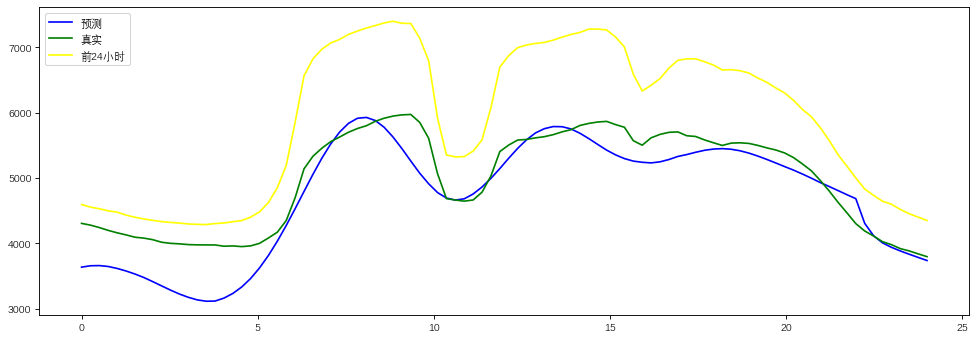

In [136]:
picture(test_seq, 200)

预测训练集里的某一样本

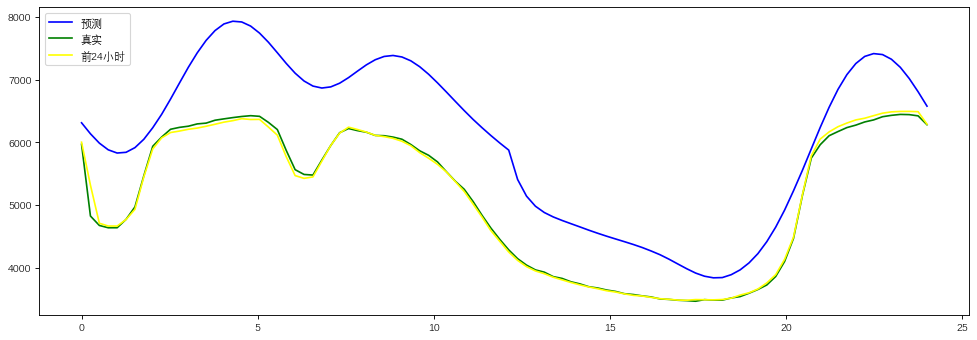

In [137]:
picture(train_seq, 6000)

采用绝对百分比误差（APE）对模型的预测准确度进行评价

单个样本的APE：|y预测 - y真实| ÷ y真实 × 100%

In [138]:
def APE_list(test_seq):  # 预测的每个24小时的平均APE组成的列表
    list1 = []
    for i in test_seq:
        pred = lstmnet(i[0].reshape(1, 288, 9))
        true_label = i[1] * (v_max - v_min) + v_min
        true_label = true_label.detach().numpy()
        true_pred = pred * (v_max - v_min) + v_min
        true_pred = true_pred.reshape(96)
        true_pred = true_pred.detach().numpy()
        num = sum(abs(true_pred - true_label) / true_label) / 96
        list1.append(num)

    return list1
# max(list1), min(list1),list1.index()

In [139]:
for x, y in testloader:
    pred = lstmnet(x)
    true_pred = pred * (v_max - v_min) + v_min
    true_pred = true_pred.detach().numpy()
    true_label = y * (v_max - v_min) + v_min
    true_label = true_label.numpy()
    APE_array = abs(true_pred - true_label) / true_label
    list1 = (sum(APE_array.T)) / 96
str(sum(list1) / len(list1) * 100) + '%'

'10.049021592333931%'

In [140]:
# 保存列表
np.save('lstm11_mape', list1)

在测试数据上的MAPE

In [141]:
list1 = APE_list(test_seq)
str(sum(list1) / len(list1) * 100) + '%'

'10.04902165539533%'

In [142]:
# 6.78093480712038%      学习率0.01
# 5.457269109252522%
# 10.8477214097637%
# 5.918630078359966%
# 4.128226396528361%
# 5.009450431216786%
# 3.411001186655329%
# 3.415735066096812%
# 3.6064668900955903%
# 2.931724167594483%
# 3.5383127694291887%
# 3.6416746837545193%
# 2.734221281214112%     学习率0.001
# 2.61618469617871%
# 2.7958986624054885%
# 2.585664801703568%
# 2.582486880934125%
# 2.6732309579117643%
# 2.615206301861146%
# 2.5464260169121267%  1.9710747880473198% 
# 2.4541228872315464%  1.8511893208963026%  2_11
# 2.534567535340079%   1.957282373732377%
# 2.5593638719166187%   1.980094143426348%
# 2.50789938291546%   1.918110005268104%
# 2.573603406381192%   1.963949082294637%
# 2.5465026439435503%   1.9307469520897989%
# 2.741571391454152%   2.184090732690481%

In [143]:
# 每次训练后若模型在测试集上的损失减小，则保存这次训练的模型，若连续6次训练在测试集上的损失没有小于之前的模型，则将之前的模型作为最终的模型。
torch.save(lstmnet.state_dict(), 'lstmnet_2_11')

加载训练好的模型参数

In [144]:
lstmnet.load_state_dict(torch.load('lstmnet_2_11'))

<All keys matched successfully>

测试数据的APE分布的箱线图

<Axes: >

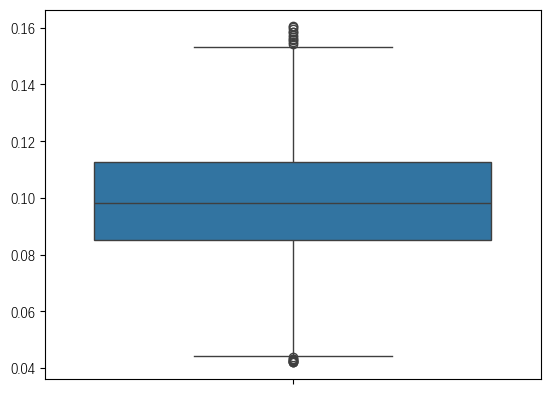

In [145]:
sns.boxplot(data=list1)

(0.0, 0.06)

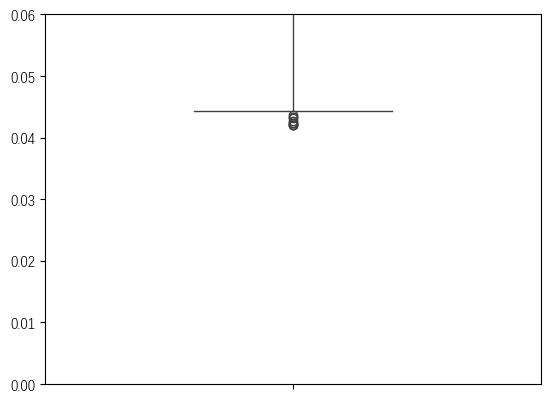

In [146]:
sns.boxplot(data=list1)
plt.ylim(0, 0.06)

In [147]:
min(list1)

0.04197211515323337

In [148]:
max(list1)

0.16048191106528975

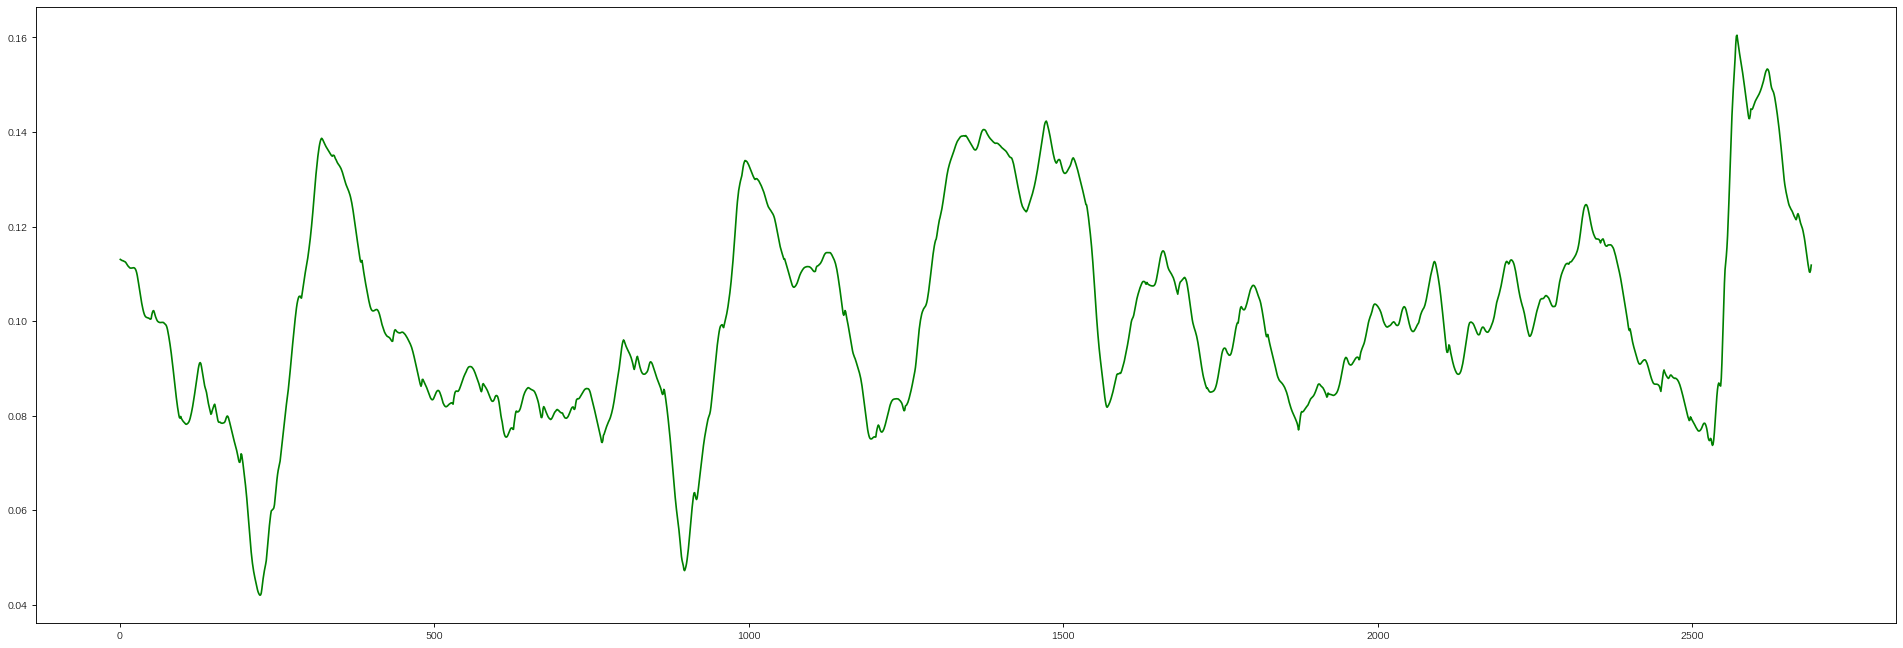

In [149]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 2689, len(list1), endpoint=True)
plt.plot(X, list1, color='green')
plt.show()

测试数据负荷值的折线图

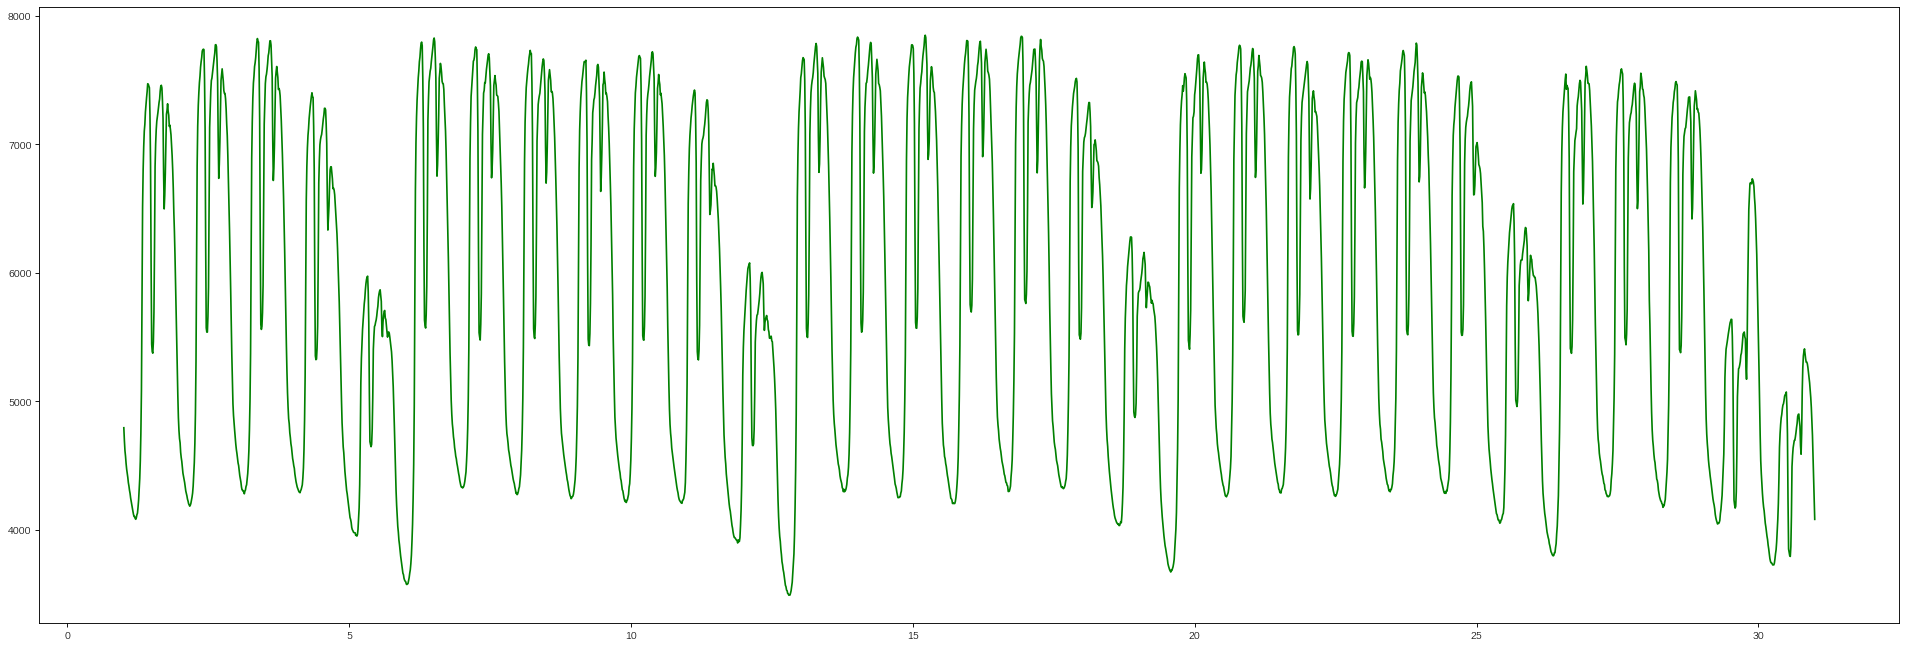

In [150]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 31, len(test), endpoint=True)
plt.plot(X, test['value'], color='green')
plt.show()

2022年12月30日和31日的预测误差较大，观察12月30日的数据发现，这天为周五，气象数据未发现异常，且不是节假日，12月31日才是元旦假期，但负荷相较前一天出现了明显的下降，推测这是导致误差较大的原因。

除去误差较大的预测结果后

In [151]:
list2 = list1[:2500]

In [152]:
str(sum(list2) / len(list2) * 100) + '%'

'9.885939126573891%'

<Axes: >

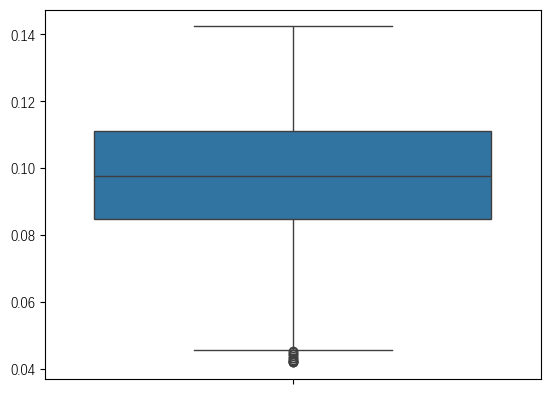

In [153]:
sns.boxplot(data=list2)

(0.0, 0.06)

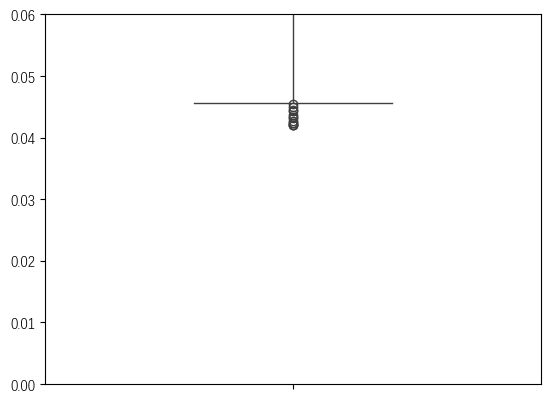

In [154]:
sns.boxplot(data=list2)
plt.ylim(0, 0.06)

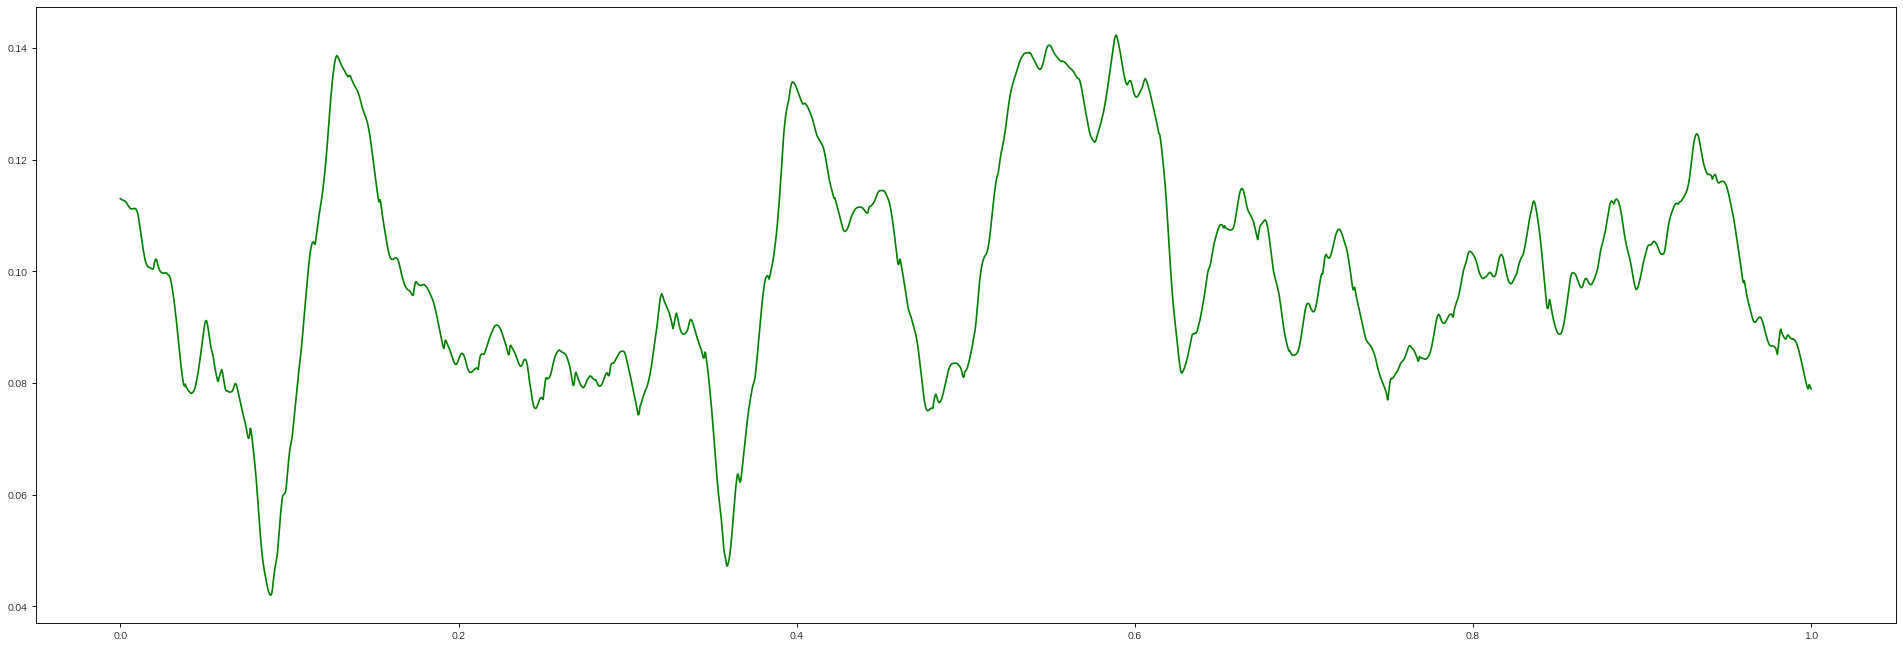

In [155]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(0, 1, len(list2), endpoint=True)
plt.plot(X, list2, color='green')
plt.show()